# 第13回のクラスタリングの課題の回答例

- センサーデータについて、以下の6つのペアについて、以下の各アルゴリズムで4つのクラスタにクラスタリングし、その結果を散布図で描写してください。
    - KMeans
    - GMM
    - 階層クラスタリング(Ward法)
    - DBSCAN
    - 階層クラスタリング(平均法)
        - cluster.AgglomerativeClusteringにおいて、linkage="average"と指定してください。

- センサーのペア
    - ("Steering Wheel Absolute Angle", "Yaw Rate 1(learmed data)")
    - ("Engine Speed", "Yaw Rate 1(learmed data)")
    - ("Engine Speed", "Vehicle Speed")
    - ("Lateral Sensor Value", "Yaw Rate 1(learmed data)")
    - ("Vehicle Speed", "Turn Left SW")
    - ("Fuel Level Percent Average", "Acceleration Sensor Value")

- DBSCANはクラスタ数は指定できないので、適当なepsを与えてクラスタリングしてください。
- 正規化を掛けたのち、クラスタリングを行ってください。

In [3]:
# データを読み込む
import pandas as pd
import numpy as np


df_raw = pd.read_csv("../data/interim/20190605_CAN/103.486_CAR1V21_HDD2/Job1/"
                     + "SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
                     names=['vin', 'time1', 'time2', 'feature', 'value'])

# 読み替え表データ
df_feature_name = pd.read_csv("../data/interim/20190605_CAN/20190617_featureName.csv")
df_feature_name["key"] = df_feature_name["key"].str[2:]
feature_name_dict = df_feature_name.set_index("key")["featureName"].to_dict()

# 集約して横持ちに
df = (
    df_raw
    .assign(rounded_time2=np.round(df_raw.time2, 1)) # time2を小数点以下1桁(0.1)で丸めて rounded_time2 列とする
    .groupby(["vin", "time1","rounded_time2","feature"])["value"].median() # 中央値で集約
    .unstack(level=-1) # feature列について横積みにする
    .interpolate() # NA を線形補完する
    .dropna() # 残った NA （先頭にNAがあったケース）を除外する
)

# 読み替え
df = df.rename(columns=feature_name_dict)

In [4]:
# 試しに1ペア取り出す
df[["Steering Wheel Absolute Angle", "Yaw Rate 1(learmed data)"]].head()

feature                         Steering Wheel Absolute Angle  \
vin time1        rounded_time2                                  
21  201604200627 0.9                                     -7.7   
                 1.0                                     -7.7   
                 1.1                                     -7.7   
                 1.2                                     -7.7   
                 1.3                                     -7.7   

feature                         Yaw Rate 1(learmed data)  
vin time1        rounded_time2                            
21  201604200627 0.9                                0.00  
                 1.0                                0.03  
                 1.1                                0.01  
                 1.2                                0.03  
                 1.3                                0.02

In [8]:
# ペア一覧
sensor_pairs = [
    ["Steering Wheel Absolute Angle", "Yaw Rate 1(learmed data)"],
    ["Engine Speed", "Yaw Rate 1(learmed data)"],
    ["Engine Speed", "Vehicle Speed"],
    ["Lateral Sensor Value", "Yaw Rate 1(learmed data)"],
    ["Vehicle Speed", "Turn Left SW"],
    ["Fuel Level Percent Average", "Acceleration Sensor Value"],
]

In [11]:
from sklearn import cluster, mixture
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
df_scaled = (df - df.mean())/df.std()

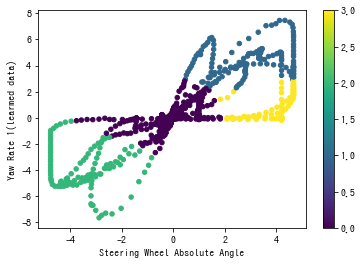

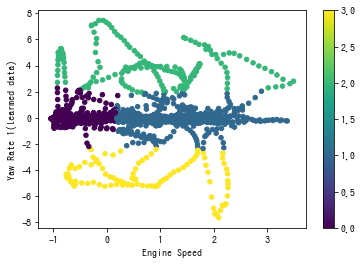

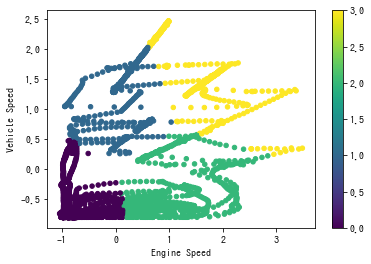

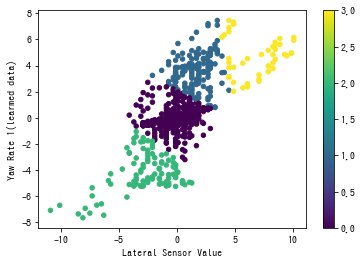

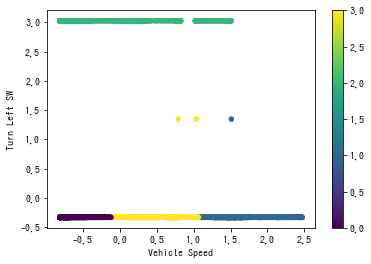

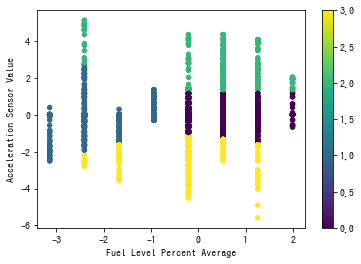

In [32]:
# KMeans
for i, j in sensor_pairs:
    m = cluster.KMeans(n_clusters=4)
    data = df_scaled[[i, j]]
    labels = m.fit_predict(data)
    df_scaled.plot.scatter(x=i, y=j, c=labels, colormap='viridis', sharex=False)
    plt.show()

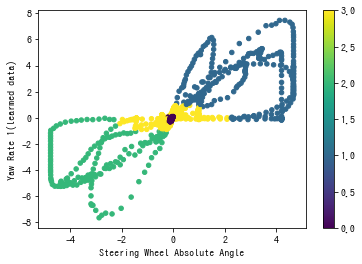

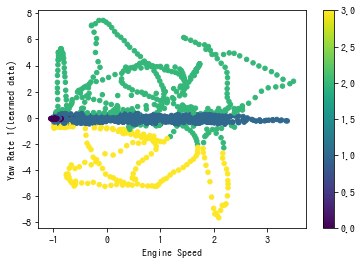

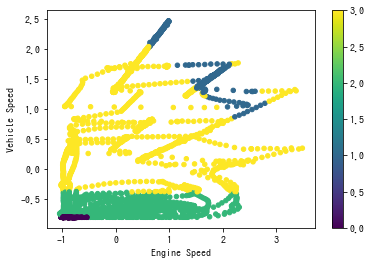

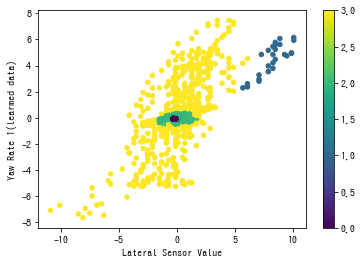

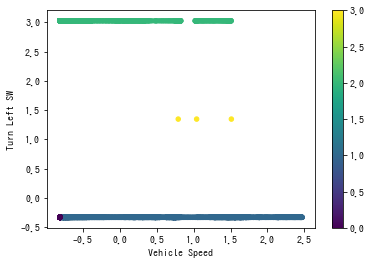

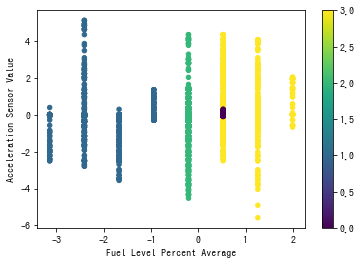

In [33]:
# GMM
for i, j in sensor_pairs:
    m = mixture.GaussianMixture(n_components=4)
    data = df_scaled[[i, j]]
    labels = m.fit_predict(data)
    df_scaled.plot.scatter(x=i, y=j, c=labels, colormap='viridis', sharex=False)
    plt.show()

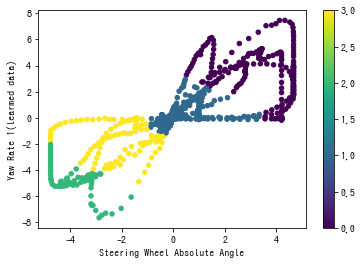

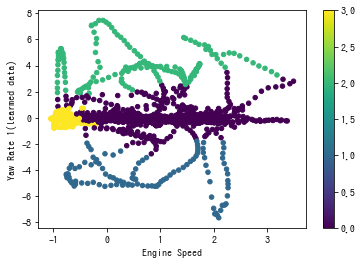

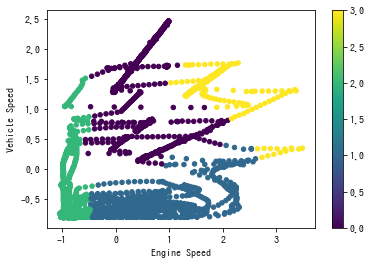

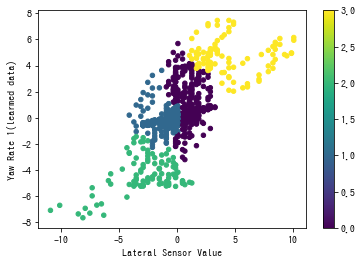

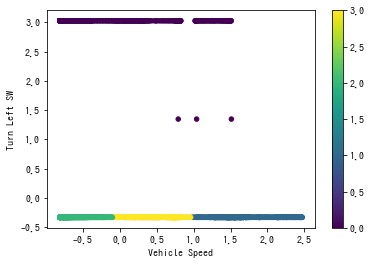

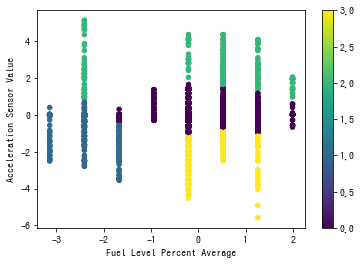

In [34]:
# 階層クラスタリング(Ward法)
for i, j in sensor_pairs:
    m = cluster.AgglomerativeClustering(
        n_clusters=4, linkage='ward')
    data = df_scaled[[i, j]]
    labels = m.fit_predict(data)
    df_scaled.plot.scatter(x=i, y=j, c=labels, colormap='viridis', sharex=False)
    plt.show()

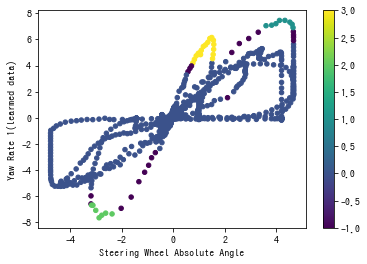

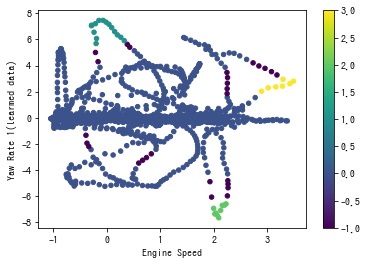

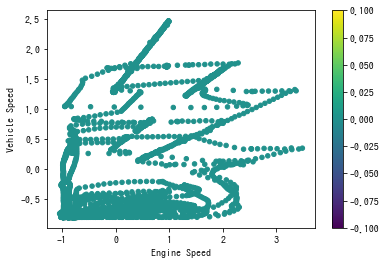

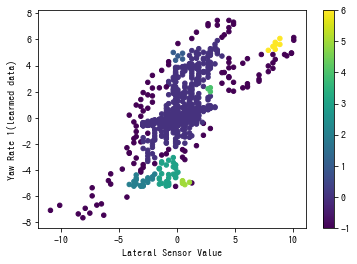

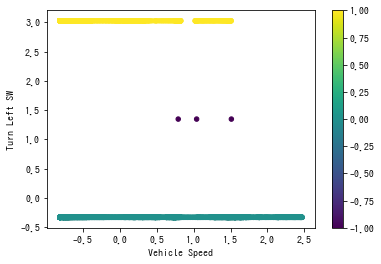

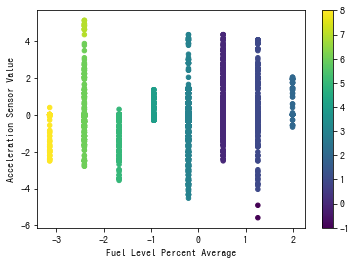

In [35]:
# DBSCAN
for i, j in sensor_pairs:
    m = cluster.DBSCAN(
        eps=0.5)
    data = df_scaled[[i, j]]
    labels = m.fit_predict(data)
    df_scaled.plot.scatter(x=i, y=j, c=labels, colormap='viridis', sharex=False)
    plt.show()

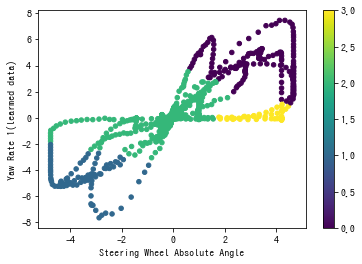

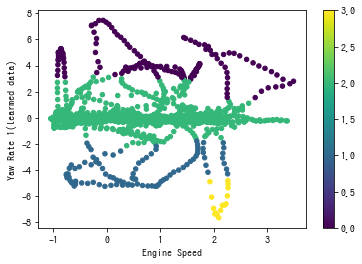

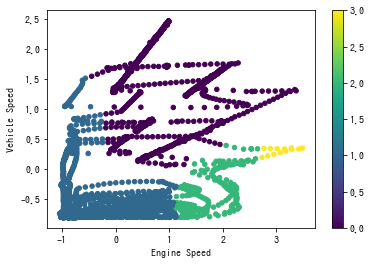

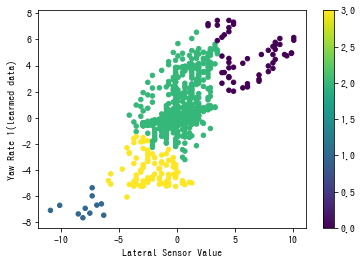

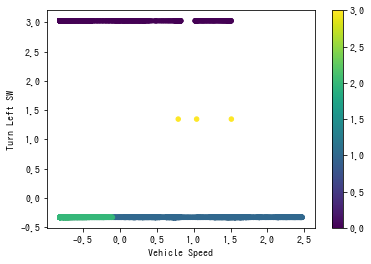

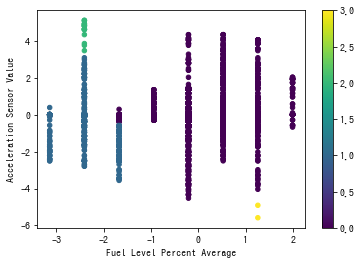

In [36]:
# 階層クラスタリング(平均法)
for i, j in sensor_pairs:
    m = cluster.AgglomerativeClustering(
        n_clusters=4, linkage="average")
    data = df_scaled[[i, j]]
    labels = m.fit_predict(data)
    df_scaled.plot.scatter(x=i, y=j, c=labels, colormap='viridis', sharex=False)
    plt.show()

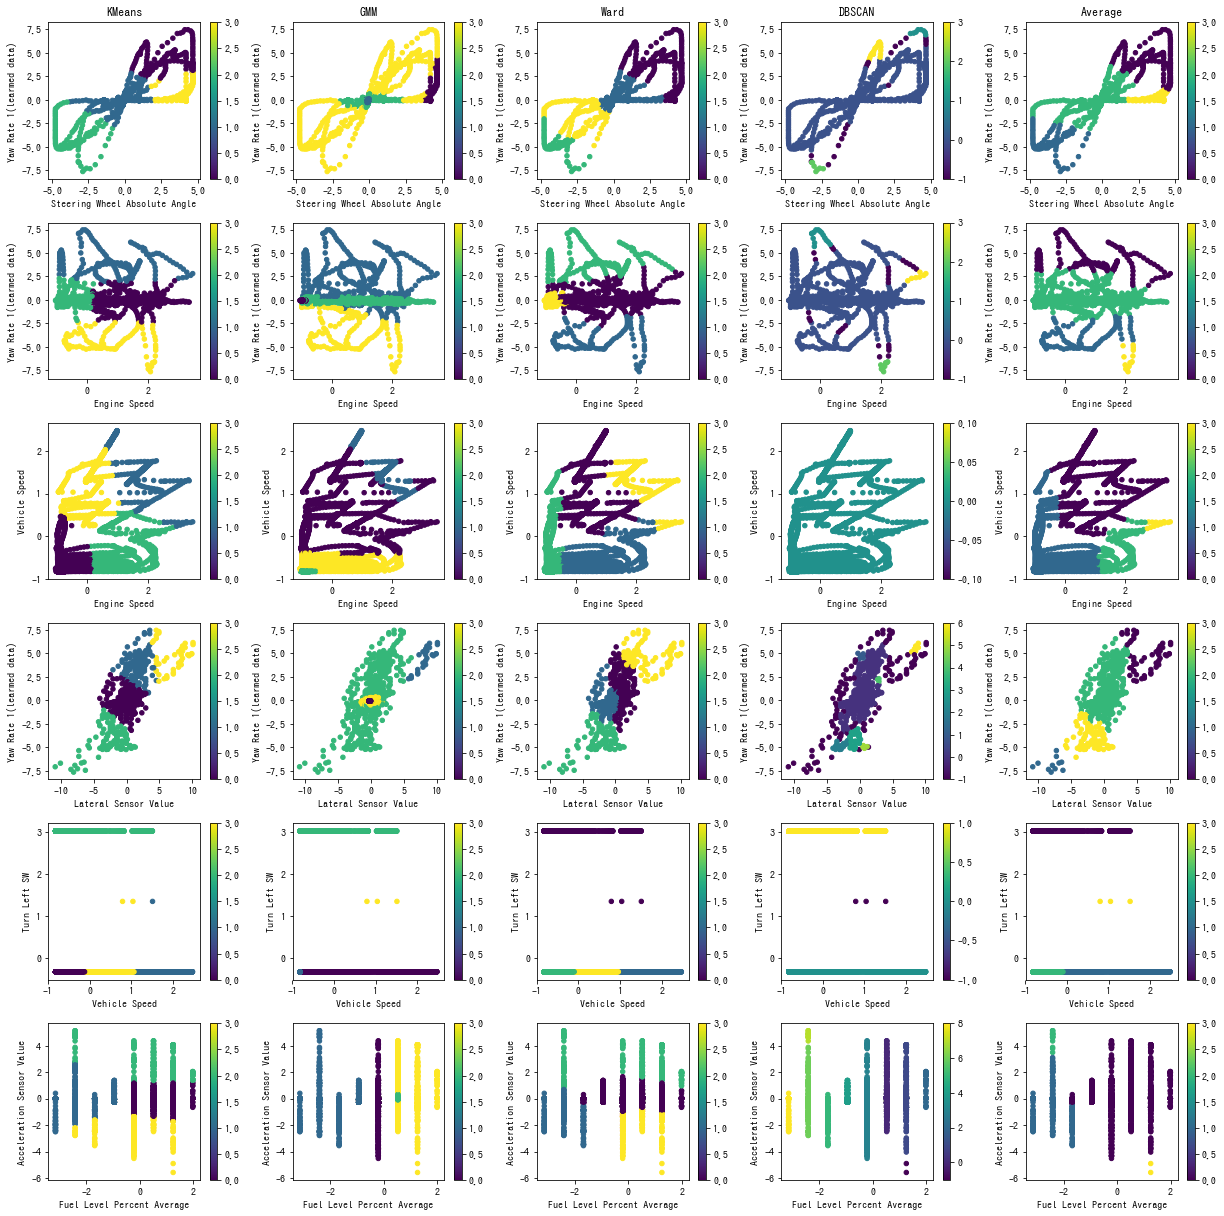

In [46]:
# (Optional) 一斉にプロットする場合
from sklearn.base import clone

model_dict = {"KMeans":cluster.KMeans(n_clusters=4), 
              "GMM":mixture.GaussianMixture(n_components=4),
              "Ward":cluster.AgglomerativeClustering(n_clusters=4, linkage="ward"),
              "DBSCAN":cluster.DBSCAN(eps=0.5),
              "Average":cluster.AgglomerativeClustering(n_clusters=4, linkage="average")}

fig = plt.figure(figsize=(17,17))
for col, algo in enumerate(model_dict.keys()):
    for row, (feature_x, feature_y) in enumerate(sensor_pairs):
        ax = fig.add_subplot(6, 5, 5 * row + col + 1)
        m = clone(model_dict[algo])
        data = df_scaled[[feature_x, feature_y]]
        labels = m.fit_predict(data)
        df_scaled.plot.scatter(x=feature_x, y=feature_y, c=labels, colormap='viridis', 
                               sharex=False, ax=ax)
        if row == 0:
            ax.set(title=algo)
    
plt.tight_layout()